# To visualize small cutouts in Rubin and Euclid together

#### helpers and imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.geom as geom
import lsst.afw.geom as afwGeom

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astroquery.ipac.irsa import Irsa
import fsspec

from scipy.optimize import linear_sum_assignment
from scipy.stats import gaussian_kde
import matplotlib.lines as mlines

def robust_imshow(ax, img, title="", p=(1, 99)):
    if img is None:
        ax.set_title(f"{title} (missing)")
        ax.axis("off")
        return
    lo, hi = np.nanpercentile(img, p)
    ax.imshow(img, origin="lower", vmin=lo, vmax=hi)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])

def save_bundle(path, **kw):
    np.savez_compressed(path, **{k: v for k, v in kw.items() if v is not None})
    print("saved:", path)


def load_euclid_cutouts(
    ra, dec, size_arcsec,
    bands=("VIS", "Y", "J", "H"),
    collection="euclid_DpdMerBksMosaic",
    radius_arcsec=60,
):
    coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame="icrs")
    tab = Irsa.query_sia(pos=(coord, radius_arcsec * u.arcsec), collection=collection).to_table()
    if "dataproduct_subtype" in tab.colnames:
        tab = tab[tab["dataproduct_subtype"] == "science"]

    out = {b: None for b in bands}
    wcs_out = {}

    for b in bands:
        rows = tab[tab["energy_bandpassname"] == b] if "energy_bandpassname" in tab.colnames else tab
        if len(rows) == 0:
            continue

        url = rows["access_url"][0]

        with fsspec.open(url, "rb") as f:
            with fits.open(f, memmap=False) as hdul:
                wcs0 = WCS(hdul[0].header)
                cut = Cutout2D(hdul[0].data, coord, size_arcsec * u.arcsec, wcs=wcs0)
                out[b] = np.array(cut.data, dtype=np.float32)
                wcs_out[b] = cut.wcs  # cutout-aware WCS

    return out, wcs_out


def load_rubin_cutouts(
    ra, dec, size_arcsec, bands,
    repo="dp1",
    collection="LSSTComCam/DP1",
):
    butler = Butler(repo, collections=collection)

    pixscale = 0.2  # arcsec/pix (fine for this visual/astrometry check)
    n = int(np.round(size_arcsec / pixscale))
    if n % 2 == 1:
        n += 1

    imgs = {b: None for b in bands}
    wcs_local = {}  # <- WCS in CUTOUT pixel coords (0..N-1)

    for b in bands:
        refs = list(butler.query_datasets(
            "deep_coadd",
            where="band.name = band AND patch.region OVERLAPS POINT(ra, dec)",
            bind={"band": b, "ra": ra, "dec": dec},
            with_dimension_records=True,
            order_by=["patch.tract"],
        ))
        if not refs:
            continue

        dataId = refs[0].dataId
        wcs_full = butler.get("deep_coadd.wcs", dataId=dataId)

        sp = geom.SpherePoint(ra, dec, geom.degrees)
        xy_full = geom.PointI(wcs_full.skyToPixel(sp))

        bbox = geom.BoxI(
            xy_full - geom.ExtentI(n, n)//2,
            geom.ExtentI(n, n)
        )

        cut = butler.get("deep_coadd", dataId=dataId, parameters={"bbox": bbox})
        imgs[b] = cut.image.array

        # --- key: make a WCS whose pixel (0,0) corresponds to bbox.min in the full image ---
        x0, y0 = bbox.getMinX(), bbox.getMinY()
        wcs_local[b] = wcs_full.copyAtShiftedPixelOrigin(geom.Extent2D(-x0, -y0))


    return imgs, wcs_local

### Target

In [2]:
ra, dec = 53.16, -28.10 #this is center of ECDFS (Rubin spans ~1degree diameter)
size_arcsec = 60.0
bands_rubin = ["u","g","r","i","z","y"]
bands_euclid = ["VIS","Y","J","H"]


### Plot

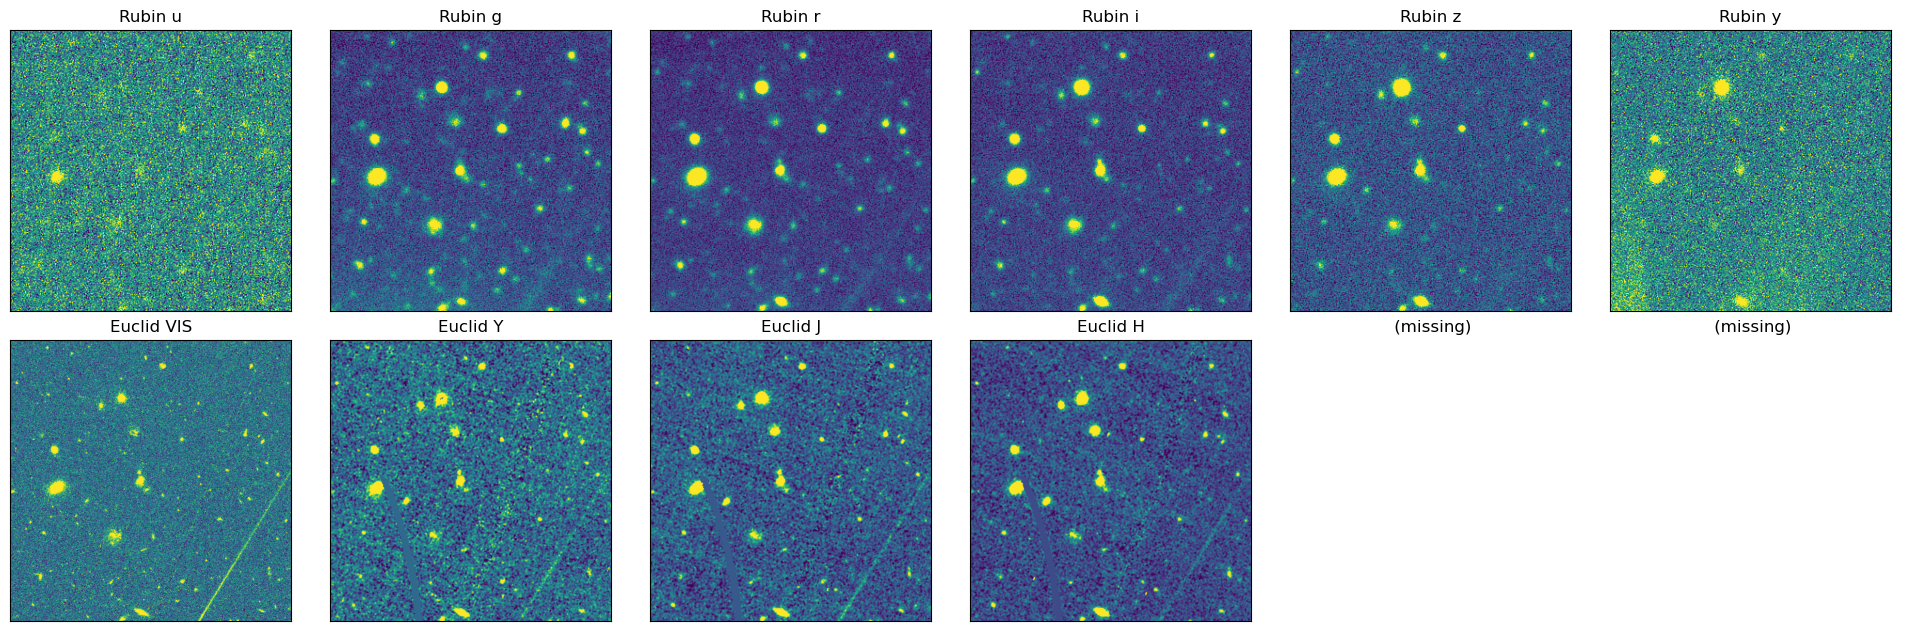

In [3]:
rub, rub_wcs = load_rubin_cutouts(ra, dec, size_arcsec, bands_rubin)
euc, euc_wcs = load_euclid_cutouts(ra, dec, size_arcsec, bands_euclid)

ncol = max(len(bands_rubin), len(bands_euclid))
fig, axes = plt.subplots(2, ncol, figsize=(3.2*ncol, 6.2), constrained_layout=True)

for j in range(ncol):
    ax = axes[0, j]
    b = bands_rubin[j] if j < len(bands_rubin) else ""
    robust_imshow(ax, rub.get(b), f"Rubin {b}" if b else "")

for j in range(ncol):
    ax = axes[1, j]
    b = bands_euclid[j] if j < len(bands_euclid) else ""
    robust_imshow(ax, euc.get(b), f"Euclid {b}" if b else "")

plt.show()


In [5]:
# ---------- peak finder (local maxima + robust threshold) ----------
def find_peaks(img, nsigma=10.0, border=10, top=200):
    m = np.nanmedian(img)
    s = 1.4826*np.nanmedian(np.abs(img-m))  # MAD -> sigma
    thr = m + nsigma*s
    a = np.nan_to_num(img, nan=-np.inf)

    c = a[1:-1,1:-1]
    neigh = [a[:-2,1:-1], a[2:,1:-1], a[1:-1,:-2], a[1:-1,2:],
             a[:-2,:-2], a[:-2,2:],  a[2:,:-2],   a[2:,2:]]
    locmax = np.logical_and.reduce([c >= n for n in neigh])
    mask = (c > thr) & locmax

    ys, xs = np.where(mask)
    ys, xs = ys+1, xs+1

    good = (xs>=border)&(xs<img.shape[1]-border)&(ys>=border)&(ys<img.shape[0]-border)
    xs, ys = xs[good], ys[good]

    if xs.size == 0:
        return np.array([]), np.array([])

    order = np.argsort(a[ys, xs])[::-1][:top]
    return xs[order].astype(float), ys[order].astype(float)


def refine_centroids(img, xs, ys, r=5):
    outx, outy = [], []
    for x0, y0 in zip(xs.astype(int), ys.astype(int)):
        y1, y2 = max(0, y0-r), min(img.shape[0], y0+r+1)
        x1, x2 = max(0, x0-r), min(img.shape[1], x0+r+1)
        cut = img[y1:y2, x1:x2]
        yy, xx = np.mgrid[y1:y2, x1:x2]
        w = np.clip(cut - np.nanmedian(cut), 0, None)
        s = np.nansum(w)
        if s == 0:
            outx.append(float(x0)); outy.append(float(y0))
        else:
            outx.append(float(np.nansum(xx*w)/s))
            outy.append(float(np.nansum(yy*w)/s))
    return np.array(outx), np.array(outy)


# ---------- pixel -> sky  ----------
def pix_to_sky_rubin(wcs, x, y):
    sp = wcs.pixelToSky(geom.Point2D(float(x), float(y)))
    return sp.getRa().asDegrees(), sp.getDec().asDegrees()

def pix_to_sky_astropy(wcs, x, y):
    ra, dec = wcs.all_pix2world([[float(x), float(y)]], 0)[0]
    return float(ra), float(dec)


def skycoords_from_peaks(img, wcs, kind="rubin", nsigma=10, top=200, border=10, refine_r=5):
    xs, ys = find_peaks(img, nsigma=nsigma, border=border, top=top)
    if xs.size == 0:
        return SkyCoord([], [], unit="deg", frame="icrs")

    if refine_r and refine_r > 0:
        xs, ys = refine_centroids(img, xs, ys, r=refine_r)

    ra = np.empty(len(xs), dtype=float)
    dec = np.empty(len(xs), dtype=float)

    if kind == "rubin":
        for i, (x, y) in enumerate(zip(xs, ys)):
            ra[i], dec[i] = pix_to_sky_rubin(wcs, x, y)
    else:
        radec = wcs.all_pix2world(np.column_stack([xs, ys]), 0)
        ra[:] = radec[:, 0].astype(float)
        dec[:] = radec[:, 1].astype(float)

    return SkyCoord(ra*u.deg, dec*u.deg, frame="icrs")


# ---------- Hungarian one-to-one matching ----------
def hungarian_match(ref_sky, cand_sky, max_sep_arcsec=0.6):
    if len(ref_sky) == 0 or len(cand_sky) == 0:
        return np.array([], dtype=int), np.array([], dtype=int), np.array([])

    sep = ref_sky[:, None].separation(cand_sky[None, :]).to(u.arcsec).value
    cost = sep.copy()
    cost[cost > max_sep_arcsec] = 1e6

    r, c = linear_sum_assignment(cost)
    ok = cost[r, c] < 1e5
    return r[ok], c[ok], sep[r[ok], c[ok]]


In [9]:
# ---------- all bands vs Euclid VIS ----------
ref = skycoords_from_peaks(
    euc["VIS"], euc_wcs["VIS"],
    kind="astropy", nsigma=12, top=400
)

# Rubin bands
for b in ["u","g","r","i","z"]:
    cand = skycoords_from_peaks(
        rub[b], rub_wcs[b],
        kind="rubin", nsigma=10, top=200
    )
    ri, ci, sep = hungarian_match(ref, cand, max_sep_arcsec=1.5)
    print(f"Rubin {b} vs Euclid VIS: matches={len(sep):3d}  "
          f"median={np.median(sep) if len(sep) else np.nan:.4f} arcsec")

# Euclid bands
for b in ["VIS","Y","J","H"]:
    cand = skycoords_from_peaks(
        euc[b], euc_wcs[b],
        kind="astropy", nsigma=12, top=400
    )
    ri, ci, sep = hungarian_match(ref, cand, max_sep_arcsec=0.3)
    print(f"Euclid {b} vs Euclid VIS: matches={len(sep):3d}  "
          f"median={np.median(sep) if len(sep) else np.nan:.4f} arcsec")


Rubin u vs Euclid VIS: matches=  1  median=0.0998 arcsec
Rubin g vs Euclid VIS: matches= 13  median=0.0392 arcsec
Rubin r vs Euclid VIS: matches= 13  median=0.0264 arcsec
Rubin i vs Euclid VIS: matches= 13  median=0.0138 arcsec
Rubin z vs Euclid VIS: matches=  6  median=0.0153 arcsec
Euclid VIS vs Euclid VIS: matches= 33  median=0.0000 arcsec
Euclid Y vs Euclid VIS: matches= 15  median=0.0277 arcsec
Euclid J vs Euclid VIS: matches= 15  median=0.0269 arcsec
Euclid H vs Euclid VIS: matches= 15  median=0.0348 arcsec


# Larger 

In [12]:
ra, dec = 53.16, -28.10 #this is center of ECDFS (Rubin spans ~1degree diameter)
size_arcsec = 500
bands_rubin = ["u","g","r","i","z","y"]
bands_euclid = ["VIS","Y","J","H"]

rub, rub_wcs = load_rubin_cutouts(ra, dec, size_arcsec, bands_rubin)
euc, euc_wcs = load_euclid_cutouts(ra, dec, size_arcsec, bands_euclid)


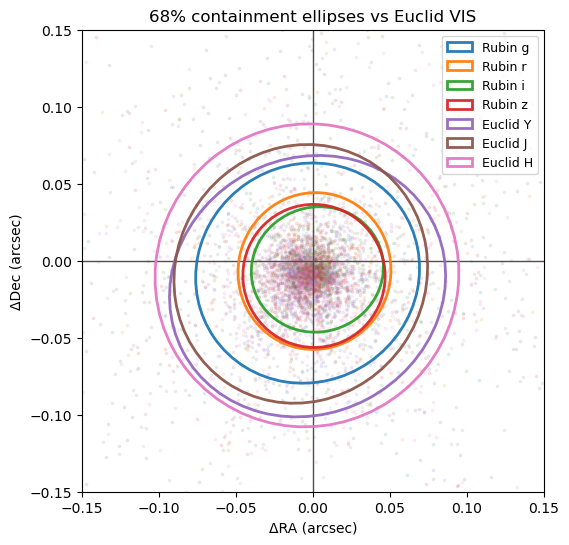

In [55]:
from matplotlib.patches import Ellipse

# 2D chi-square quantiles (df=2): P(<=q)=p
# 68% -> 2.279, 95% -> 5.991, 99% -> 9.210
CHI2_2D = {0.68: 2.279, 0.95: 5.991, 0.99: 9.210}

def _robust_center(x, y):
    return np.nanmedian(x), np.nanmedian(y)

def _sigma_clip_xy(x, y, nsig=6.0, iters=2):
    x = np.asarray(x); y = np.asarray(y)
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size < 10:
        return x, y
    for _ in range(iters):
        cx, cy = _robust_center(x, y)
        r = np.hypot(x - cx, y - cy)
        med = np.median(r)
        mad = 1.4826 * np.median(np.abs(r - med))
        if mad <= 0:
            break
        keep = r < (med + nsig * mad)
        x, y = x[keep], y[keep]
        if x.size < 10:
            break
    return x, y

def add_containment_ellipse(ax, x, y, p=0.68, clip=True, nsig=6.0, iters=2, **kwargs):
    """
    Draw a standard 2D Gaussian containment ellipse for fraction p of points.
    Uses sample covariance of (optionally sigma-clipped) points.
    """
    x = np.asarray(x); y = np.asarray(y)
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size < 8:
        return None

    if clip:
        x, y = _sigma_clip_xy(x, y, nsig=nsig, iters=iters)
        if x.size < 8:
            return None

    # center (robust)
    cx, cy = _robust_center(x, y)

    # covariance
    X = np.vstack([x - cx, y - cy])
    C = np.cov(X)
    if not np.all(np.isfinite(C)):
        return None

    # eigen decomposition (major/minor axes)
    vals, vecs = np.linalg.eigh(C)
    order = np.argsort(vals)[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # angle of major axis
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))

    # scale by chi-square quantile for 2D containment
    q = CHI2_2D.get(p, 2.279)
    width  = 2.0 * np.sqrt(q * vals[0])   # full width
    height = 2.0 * np.sqrt(q * vals[1])   # full height

    e = Ellipse((cx, cy), width=width, height=height, angle=angle, fill=False, **kwargs)
    ax.add_patch(e)
    return e


# --------- plot: ellipses vs Euclid VIS ----------
colors = {
    "Rubin u": "tab:cyan",
    "Rubin g": "tab:blue",
    "Rubin r": "tab:orange",
    "Rubin i": "tab:green",
    "Rubin z": "tab:red",
    "Euclid Y": "tab:purple",
    "Euclid J": "tab:brown",
    "Euclid H": "tab:pink",
}

fig, ax = plt.subplots(figsize=(6.2, 6.0))

# (optional) faint scatter, neutral
for name, dra, ddec in series:
    ax.scatter(dra, ddec, s=3, alpha=0.1, c=colors.get(name,"k"), zorder=1)

# 68% ellipse per band
for name, dra, ddec in series:
    add_containment_ellipse(
        ax, dra, ddec,
        p=0.68,
        clip=True, nsig=6.0, iters=2,
        edgecolor=colors.get(name, "k"),
        linewidth=2.0,
        alpha=0.95,
        zorder=3,
        label=name,
    )

ax.axhline(0, color="0.3", lw=1)
ax.axvline(0, color="0.3", lw=1)
ax.set_aspect("equal", "box")

# zoom for display only (doesn't affect ellipse)
ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-0.15, 0.15)

ax.set_xlabel("ΔRA (arcsec)")
ax.set_ylabel("ΔDec (arcsec)")
ax.set_title("68% containment ellipses vs Euclid VIS")
ax.legend(loc="upper right", fontsize=9, frameon=True)
plt.show()


In [71]:
pos_series = []

# Euclid VIS reference
ref = skycoords_from_peaks(
    euc["VIS"], euc_wcs["VIS"],
    kind="astropy", nsigma=10, top=200
)

# ---------- Rubin vs Euclid VIS ----------
for b in ["g", "r", "i", "z"]:
    cand = skycoords_from_peaks(
        rub[b], rub_wcs[b],
        kind="rubin", nsigma=10, top=200
    )

    ri, ci, sep = hungarian_match(ref, cand, max_sep_arcsec=0.6)
    if len(ri) == 0:
        continue

    ra  = cand.ra.deg[ci]
    dec = cand.dec.deg[ci]

    dra  = (cand.ra[ci]  - ref.ra[ri]).to(u.arcsec).value * np.cos(np.deg2rad(ref.dec.deg[ri]))
    ddec = (cand.dec[ci] - ref.dec[ri]).to(u.arcsec).value

    pos_series.append((f"Rubin {b}", ra, dec, dra, ddec))

# ---------- Euclid Y/J/H vs Euclid VIS ----------
for b in ["Y", "J", "H"]:
    cand = skycoords_from_peaks(
        euc[b], euc_wcs[b],
        kind="astropy", nsigma=10, top=200
    )

    ri, ci, sep = hungarian_match(ref, cand, max_sep_arcsec=0.6)
    if len(ri) == 0:
        continue

    ra  = cand.ra.deg[ci]
    dec = cand.dec.deg[ci]

    dra  = (cand.ra[ci]  - ref.ra[ri]).to(u.arcsec).value * np.cos(np.deg2rad(ref.dec.deg[ri]))
    ddec = (cand.dec[ci] - ref.dec[ri]).to(u.arcsec).value

    pos_series.append((f"Euclid {b}", ra, dec, dra, ddec))

print("Built pos_series entries:")
for x in pos_series:
    print(x[0], "N =", len(x[1]))

Built pos_series entries:
Rubin g N = 83
Rubin r N = 77
Rubin i N = 114
Rubin z N = 99
Euclid Y N = 127
Euclid J N = 111
Euclid H N = 112


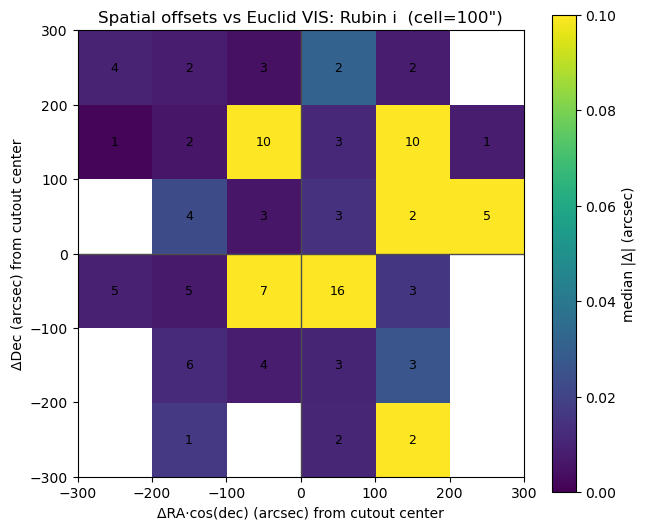

In [73]:
def plot_spatial_offsets_vs_vis_cellsize(pos_series, which="Rubin i",
                                        cell_arcsec=20.0, min_count=10,
                                        stat="median", vmax=None):
    # pick series
    for name, ra, dec, dra, ddec in pos_series:
        if name == which:
            ra = np.asarray(ra); dec = np.asarray(dec)
            dra = np.asarray(dra); ddec = np.asarray(ddec)
            break
    else:
        raise ValueError(f"{which} not found in pos_series")

    # convert to a local tangent-ish plane in arcsec for binning
    ra0 = np.median(ra)
    dec0 = np.median(dec)
    x = (ra - ra0) * np.cos(np.deg2rad(dec0)) * 3600.0  # arcsec
    y = (dec - dec0) * 3600.0                           # arcsec

    # offsets to summarize
    r = np.hypot(dra, ddec)  # arcsec magnitude

    # define grid edges at requested cell size
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    xb = np.arange(np.floor(xmin/cell_arcsec)*cell_arcsec,
                   np.ceil (xmax/cell_arcsec)*cell_arcsec + cell_arcsec,
                   cell_arcsec)
    yb = np.arange(np.floor(ymin/cell_arcsec)*cell_arcsec,
                   np.ceil (ymax/cell_arcsec)*cell_arcsec + cell_arcsec,
                   cell_arcsec)

    nx, ny = len(xb)-1, len(yb)-1
    grid = np.full((ny, nx), np.nan, dtype=float)
    cnt  = np.zeros((ny, nx), dtype=int)

    # bin
    ix = np.clip(np.digitize(x, xb) - 1, 0, nx-1)
    iy = np.clip(np.digitize(y, yb) - 1, 0, ny-1)

    for j in range(ny):
        for i in range(nx):
            m = (ix == i) & (iy == j)
            n = int(m.sum())
            cnt[j, i] = n
            if n < min_count:
                continue
            vals = r[m]
            if stat == "median":
                grid[j, i] = np.median(vals)
            elif stat == "p68":
                grid[j, i] = np.quantile(vals, 0.68)
            else:
                raise ValueError("stat must be 'median' or 'p68'")

    # plot (axes in RA/Dec-ish arcsec from center)
    fig, ax = plt.subplots(figsize=(7.2, 6.2))
    im = ax.imshow(
        grid, origin="lower",
        extent=[xb[0], xb[-1], yb[0], yb[-1]],
        vmin=0, vmax=vmax, aspect="equal"
    )
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(f"{stat} |Δ| (arcsec)")

    # annotate counts
    xc = 0.5*(xb[:-1] + xb[1:])
    yc = 0.5*(yb[:-1] + yb[1:])
    for j in range(ny):
        for i in range(nx):
            if cnt[j, i] >= min_count:
                ax.text(xc[i], yc[j], f"{cnt[j,i]}", ha="center", va="center", fontsize=9)

    ax.axhline(0, color="0.3", lw=1)
    ax.axvline(0, color="0.3", lw=1)
    ax.set_xlabel("ΔRA·cos(dec) (arcsec) from cutout center")
    ax.set_ylabel("ΔDec (arcsec) from cutout center")
    ax.set_title(f"Spatial offsets vs Euclid VIS: {which}  (cell={cell_arcsec:.0f}\")")
    plt.show()

plot_spatial_offsets_vs_vis_cellsize(pos_series, which="Rubin i",
                                     cell_arcsec=100, min_count=1, stat="median",
                                     vmax=0.1)

